In [10]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from siphon.catalog import get_latest_access_url
from siphon.ncss import NCSS
import xarray as xr
import time

In [11]:
lat = 40
lon = -105
north =lat+1
south =lat-1
east=lon+1
west=lon-1

var = [
'u-component_of_wind_height_above_ground',
'v-component_of_wind_height_above_ground',
'Temperature_height_above_ground',
'Pressure_surface',
'Temperature_isobaric',
'Pressure_reduced_to_MSL_msl',
'Geopotential_height_surface',
'Total_cloud_cover_entire_atmosphere',
'Temperature_height_above_ground',
'Total_precipitation_surface_1_Hour_Accumulation',
'Convective_available_potential_energy_surface',
'Surface_lifted_index_isobaric_layer',
'Wind_speed_gust_surface',
'Hourly_Maximum_of_Upward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum',
      ]

In [12]:
latest_access_url = get_latest_access_url("http://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml", "NetcdfSubset")
ncss = NCSS(latest_access_url)
query = ncss.query()
query.accept('netcdf4')
query.all_times()
query.lonlat_box(north=north, south=south, east=east, west=west)
query.variables(frozenset(var))
open('temp.nc4', 'wb').write(ncss.get_data_raw(query))
nc = xr.load_dataset('temp.nc4')

KeyError: 'time'

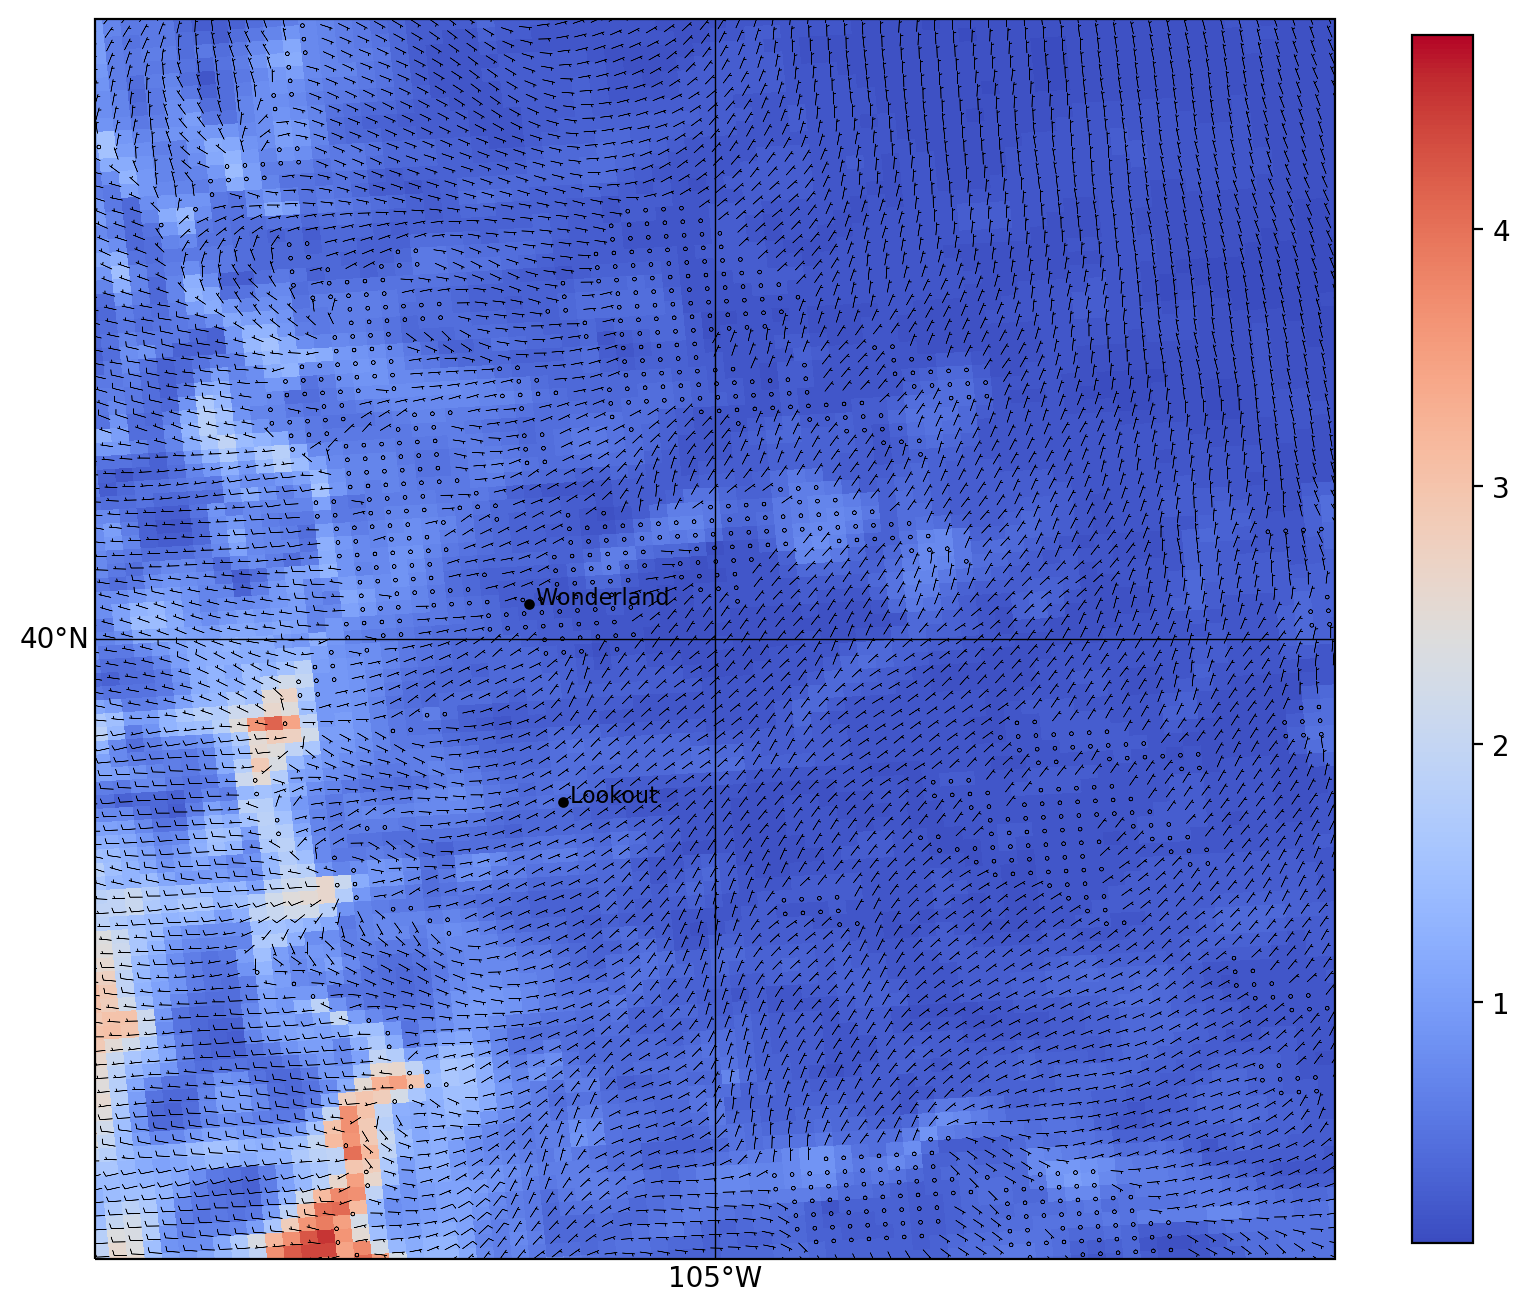

In [13]:
var_index = -1
time_index = 1 
barbs = True 
streamlines = False 
grid_size = 1

nctime = 'time'
ncvar = nc[var[var_index]]
ncname = ncvar.name

#km to meters conversion
x = ncvar.x.data*1000.
y = ncvar.y.data*1000.

grid = nc[ncvar.grid_mapping]
crs = ccrs.LambertConformal(
                            central_longitude=grid.longitude_of_central_meridian, 
                            central_latitude=grid.latitude_of_projection_origin, 
                            standard_parallels=(grid.latitude_of_projection_origin,grid.standard_parallel), 
                            globe=ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)
                            )

fig = plt.figure(figsize=(10,10), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())

plt.xlim([west, east])
plt.ylim([south, north])

mesh = ax.pcolorfast(x,y,ncvar[time_index,::].data.squeeze(), transform=crs, cmap='coolwarm')

if barbs: ax.barbs(x,y,nc[var[0]][time_index,0,::].data.squeeze(),nc[var[1]][time_index,0,::].data.squeeze(), transform=crs, length=3, linewidth=0.2)
if streamlines: ax.streamplot(x,y,nc[var[0]][time_index,0,::].data.squeeze(),nc[var[1]][time_index,0,::].data.squeeze(), transform=crs, density = 5, color='grey', arrowsize=0.5, linewidth= 0.5)

ax.scatter(-105.300, 40.056, c='black', s=8)
ax.text(-105.300, 40.056, ' Wonderland', size=8)
ax.scatter(-105.245, 39.737, c='black', s=8)
ax.text(-105.245, 39.737, ' Lookout', size=8)
# ax.scatter(-105.282, 40.133, c='black', s=8)
# ax.text(-105.282, 40.13, ' Altona', size=8)
# ax.scatter(-105.271, 40.224, c='black', s=8)
# ax.text(-105.271, 40.224, ' Lyons', size=8)
# ax.scatter(-105.419, 40.026, c='black', s=8)
# ax.text(-105.419, 40.026, ' Sugarloaf', size=8)

gl = ax.gridlines(draw_labels=True, color = 'black', linewidth=0.5)
gl.xlocator = mticker.FixedLocator(np.arange(west,east+grid_size,grid_size))
gl.ylocator = mticker.FixedLocator(np.arange(south,north+grid_size,grid_size))
gl.top_labels = False
gl.right_labels = False

plt.colorbar(mesh, shrink=0.8)
# plt.title(str(nc[nctime].data[time_index])[:-16] + ' ' + ncname[:42]);
plt.show()